In [3]:
import math
import pandas as pd
import scipy.io
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.stats import multivariate_normal
from functools import reduce
import numpy as np
%matplotlib inline

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

mat = scipy.io.loadmat('data.mat')
data = mat['data'].T
data.shape

(1990, 784)

In [4]:
lab = scipy.io.loadmat('label.mat')
label = lab['trueLabel']
label.shape

(1, 1990)

(784,)

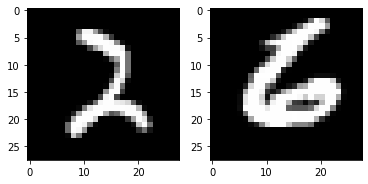

In [5]:
f = plt.figure()
f.add_subplot(1,2,1)
plt.imshow((data[500,:].reshape(28,28)).T, cmap='gray')
f.add_subplot(1,2,2)
plt.imshow((data[-1,:].reshape(28,28)).T, cmap='gray')
data[500,:].shape

In [6]:
# PCA (set r = 10)
new_data = data - np.mean(data, axis=0)
C = np.cov(new_data)
eigenvalue, eigenvectors = np.linalg.eigh(C)
#print(eigenvalue.shape, eigenvectors.shape)

eigenvectors = eigenvectors[:, np.argsort(-eigenvalue)]
eigenvalue = eigenvalue[np.argsort(-eigenvalue)]

principals = eigenvectors[:,0:10]             # set r = 10
#print(principals.shape, new_data.shape)

transformed_data = np.dot(principals.T, new_data).T
transformed_data.shape, principals.shape

((784, 10), (1990, 10))

In [7]:
# Initialization
init_covariances = np.identity(784)
init_means = np.random.normal(0,1,784)
init_weights = np.array([0.5,0.5])
pi_1 = pi_2 = 0.5

x_tilda = transformed_data
mu_tilda_1 = x_tilda - init_means.reshape(784,1)
lamb = [s for s in eigenvalue if s > 0.05]          # Truncate eigenvalue.

N_1 = (1/np.product(lamb))**np.exp(-(np.sum((x_tilda - mu_tilda_1)**2)/np.sum(lamb))/2)


In [8]:
# Calculate weights
def response(data, weights, means, covariances):
    n_data = len(data)
    n_clusters = 2    
    resp = np.zeros((n_data, n_clusters))
    for i in range(n_data):
        for k in range(n_clusters):
            resp[i, k] = weights[k]* N_1
    row_sums = resp.sum(axis=1)[:, np.newaxis]
    resp = resp / row_sums
    return resp
resp_1 = response(data, init_weights, init_means, init_covariances)
counts = np.sum(resp_1, axis=0)

def get_weights(counts):
    n_clusters = 2
    k= 2
    sum_count = np.sum(counts)
    weights = np.array(list(map(lambda k : counts[k]/sum_count, range(n_clusters))))
    return weights
weights = get_weights(counts).reshape(1,2)
print(weights.shape)

(1, 2)


In [9]:
def update_means(data, resp, counts):
    n_clusters = 2
    n_data = len(data)
    means = np.zeros((n_clusters, len(data[0])))
    
    for k in range(n_clusters):
        weighted_sum = reduce(lambda x,i : x + resp[i,k]*data[i],  range(n_data), 0.0)
        means[k] = weighted_sum/counts[k]
    return means
means = update_means(data, resp_1, counts)

In [10]:
def update_covariances(data, resp, counts, means):
    n_clusters = 2
    dimension = len(data[0]) # to get dimention of data
    n_data = len(data)
    covariances = np.zeros((n_clusters, dimension, dimension))
    
    for k in range(n_clusters):
        weighted_sum = reduce (lambda x, i :x + resp[i,k] *  np.outer((data[i]-means[k]), (data[i]- means[k]).T), range(n_data), np.zeros((dimension, dimension)))
        covariances[k] = weighted_sum /counts[k] 
    return covariances
covs = update_covariances(data, resp_1, counts, init_means)


In [65]:
# All together
class GMM(object):
    def __init__(self, data, k=2):
        data = np.asarray(data)
        self.m, self.n = data.shape
        self.data = data.copy()
        self.k = k
        
    def _init(self):
        self.mean_arr = np.asmatrix(np.random.random((self.k, self.n)))
        self.sigma_arr = np.array([np.asmatrix(np.identity(self.n)) for i in range(self.k)])
        self.phi = np.ones(self.k)/self.k
        self.w = np.asmatrix(np.zeros((self.m, self.k), dtype=float))
        
    def loglikelihood(self):
        ll = 0
        for i in range(self.m):
            tmp = 0
            for j in range(self.k):
                tmp += sp.stats.multivariate_normal.pdf(self.data[i, :],self.mean_arr[j, :].A1, 
                                                        self.sigma_arr[j, :])*self.phi[j]
            ll += np.log(tmp)
        return ll
    
    def fit(self, tol=1e-6):
        self._init()
        num_iters = 0
        ll = 1
        old_ll = 0
        xx = []
        yy = []
        while(ll-old_ll > tol):
            old_ll = self.loglikelihood()
            self._fit()
            num_iters += 1
            ll = self.loglikelihood()
            xx.append(num_iters)
            yy.append(ll)           
            print('Iteration %d: log-likelihood is %.2f'%(num_iters, ll))
        print('Terminate at %d-th iteration:log-likelihood is %.2f'%(num_iters, ll))
        plt.plot(xx,yy)
        plt.xlabel("Number of iterations")
        plt.ylabel("Log-likelihood")
    
    def _fit(self):
        self.e_step()
        self.m_step()
        
    def e_step(self):
        # calculate w_j^{(i)}
        for i in range(self.m):
            den = 0
            for j in range(self.k):
                num = sp.stats.multivariate_normal.pdf(self.data[i, :], self.mean_arr[j].A1, 
                                                       self.sigma_arr[j]) * self.phi[j]
                den += num
                self.w[i, j] = num
            self.w[i, :] /= den
            assert self.w[i, :].sum() - 1 < 1e-3
            
    def m_step(self):
        for j in range(self.k):
            constant = self.w[:, j].sum()
            self.phi[j] = 1/self.m * constant
            mu_j = np.zeros(self.n)
            sigma_j = np.zeros((self.n, self.n))
            for i in range(self.m):
                mu_j += (self.data[i, :] * self.w[i, j])
                sigma_j += self.w[i, j] * ((self.data[i, :] - self.mean_arr[j, :]).T * (self.data[i, :] - self.mean_arr[j, :]))
            self.mean_arr[j] = mu_j / constant
            self.sigma_arr[j] = sigma_j / constant
        #print(self.mean_arr)      

    def predict_proba(self):
        likelihood = np.zeros( (self.n, self.k) )
        for i in range(self.k):
            distribution = multivariate_normal(self.mean_arr[i], self.sigma_arr[i])
            likelihood[:,i] = distribution.pdf(data)

        numerator = self.loglikelihood()* self.w
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights
    
    def predict(self):
        weights = self.predict_proba()
        return np.argmax(weights, axis=1)

Iteration 1: log-likelihood is -17433.63
Iteration 2: log-likelihood is -17089.31
Iteration 3: log-likelihood is -16261.27
Iteration 4: log-likelihood is -14850.62
Iteration 5: log-likelihood is -12839.63
Iteration 6: log-likelihood is -10819.72
Iteration 7: log-likelihood is -9214.60
Iteration 8: log-likelihood is -7906.94
Iteration 9: log-likelihood is -7237.18
Iteration 10: log-likelihood is -6775.69
Iteration 11: log-likelihood is -6423.47
Iteration 12: log-likelihood is -6127.43
Iteration 13: log-likelihood is -5819.07
Iteration 14: log-likelihood is -5329.70
Iteration 15: log-likelihood is -4974.56
Iteration 16: log-likelihood is -4756.95
Iteration 17: log-likelihood is -4598.93
Iteration 18: log-likelihood is -4442.30
Iteration 19: log-likelihood is -4277.90
Iteration 20: log-likelihood is -4149.79
Iteration 21: log-likelihood is -4052.51
Iteration 22: log-likelihood is -3984.21
Iteration 23: log-likelihood is -3969.35
Iteration 24: log-likelihood is -3954.12
Iteration 25: log-l

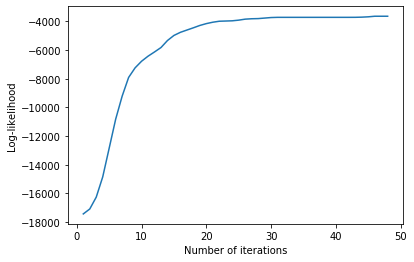

In [66]:
gmm = GMM(transformed_data)
gmm.fit()

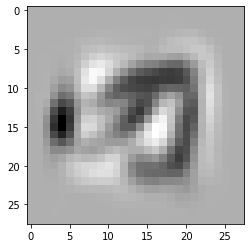

In [67]:
## New Image
mean = gmm.mean_arr
new_image = np.dot(transformed_data,  mean[0].T).reshape(28,28)
plt.imshow(new_image, cmap='gray')

In [133]:
# K-mean Classification
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(data)
y_kmeans = kmeans.predict(data)
print("K-mean classificaiton is: ", y_kmeans)

# True label
lab = scipy.io.loadmat('label.mat')
label = lab['trueLabel']
print("True label for numbers classification is: ", label)

K-mean classificaiton is:  [0 0 0 ... 0 1 1]
True label for numbers classification is:  [[2 2 2 ... 6 6 6]]


In [134]:
# Calculate the rate of False (K-mean).
False_1 = len([i for i in range(len(y_kmeans)) if y_kmeans[i] ==0 and label[0][i] == 2])
False_Rate_1 = False_1/len(y_kmeans)
print("False Rate of Number 6 classification(K-Mean) is %.4f"%(False_Rate_1))


False_2 = len([i for i in range(len(y_kmeans)) if y_kmeans[i] ==1 and label[0][i] == 6])
False_Rate_2 = False_2/len(y_kmeans)
print("False Rate of Number 2 classification (K-Mean) is %.4f"%(False_Rate_2))

False Rate of Number 6 classification(K-Mean) is 0.4905
False Rate of Number 2 classification (K-Mean) is 0.4472


In [135]:
# GMM Classification
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2)
gmm.fit(data)
pred = gmm.predict(data)

In [137]:
False_1 = len([i for i in range(len(y_kmeans)) if pred[i] ==0 and label[0][i] == 6])
False_Rate_1 = False_1/len(y_kmeans)
print("False Rate of Number 6 classification (GMM) is %.4f"%(False_Rate_1))


False_2 = len([i for i in range(len(y_kmeans)) if pred[i] ==1 and label[0][i] == 2])
False_Rate_2 = False_2/len(y_kmeans)
print("False Rate of Number 2 classification (GMM) is %.4f"%(False_Rate_2))


False Rate of Number 6 classification (GMM) is 0.0266
False Rate of Number 2 classification (GMM) is 0.0281


(1990, 784)